# Propagation des incertitudes

L'objectif de cette étude est de créer un modèle probabiliste dans lequel, pour une année donnée, l'année de départ effectif moyen à la retraite se situe entre l'âge du COR (borne inférieure) et l'âge de l'étude d'impact (borne supérieure).

In [1]:
from retraites.SimulateurRetraites import SimulateurRetraites
from retraites.ModelePensionProbabiliste import ModelePensionProbabiliste
from retraites.EtudeImpact import EtudeImpact
import openturns as ot
import pylab as pl
import scipy as sp
import numpy as np
import openturns.viewer as otv

## Définition des paramètres

In [2]:
simulateur = SimulateurRetraites()

In [3]:
etudeImpact = EtudeImpact(simulateur)
analyse_etudeImpact = etudeImpact.calcule()

In [4]:
analyse_COR = simulateur.pilotageCOR()

## Définition du modèle

Les paramètres suivants sont utilisés dans toutes les simulations de cet exemple :
* le solde est nul à partir de 2020, 
* le montant des dépenses est fixé à 14% du PIB,
* les âges de départ moyens effectifs augmentent progressivement vers un âge compris entre 63 et 67 ans.

In [5]:
def CalculeModele(simulateur, annee):
    """
    Calcule un modèle probabiliste dans lequel les paramètres sont fixés. 
    Les bornes de la loi uniforme pour l'âge de départ en retraite 
    augmentent progressivement. 
    """
    S = 0.0
    D = 0.14
    ageMin = analyse_COR.A[simulateur.scenario_central][simulateur.horizon]
    ageMax = 67.0
    modele = ModelePensionProbabiliste(simulateur, annee, S, D, 
                                       bornesAgeConstant = False, 
                                       ageMin = ageMin, ageMax = ageMax)
    return modele

In [6]:
nbannees = len(simulateur.annees_futures)
tableAges = ot.Sample(nbannees, 3)
for i in range(nbannees):
    annee = simulateur.annees_futures[i]
    modele = CalculeModele(simulateur, annee)
    inputDistribution = modele.getInputDistribution()
    marginaleAge = inputDistribution.getMarginal(0)
    tableAges[i, 0] = annee
    implementation = marginaleAge.getImplementation()
    if implementation.getClassName() == "Dirac":
        parameter = marginaleAge.getParametersCollection()[0]
        tableAges[i, 1] = parameter[0]
        tableAges[i, 2] = parameter[0]
    else:
        parameter = marginaleAge.getParametersCollection()[0]
        tableAges[i, 1] = parameter[0]
        tableAges[i, 2] = parameter[1]

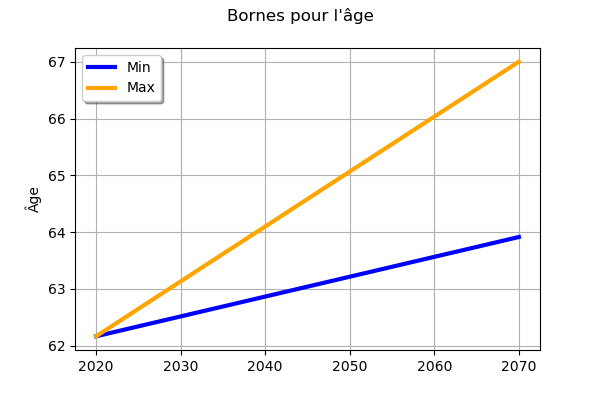

In [7]:
graph = ot.Graph("Bornes pour l'âge","","Âge",True)
curve = ot.Curve(tableAges[:,0], tableAges[:,1])
curve.setLineWidth(3)
graph.add(curve)
curve = ot.Curve(tableAges[:,0], tableAges[:,2])
curve.setLineWidth(3)
curve.setColor("orange")
graph.add(curve)
graph.setLegends(["Min", "Max"])
graph.setLegendPosition("topleft")
graph

## Comparaison entre les bornes de trajectoires d'âge probabilisée et l'étude d'impact

In [8]:
scenarios = [simulateur.scenario_central] # Scénario central : Hausse = +1.3% PIB

In [9]:
import openturns.viewer as otv

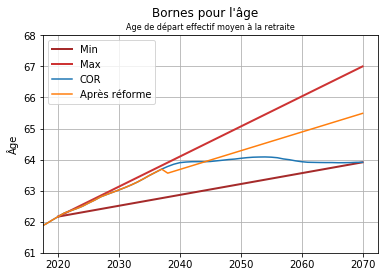

In [10]:
graph = ot.Graph("Bornes pour l'âge","","Âge",True)
curve = ot.Curve(tableAges[:,0], tableAges[:,1])
curve.setLineWidth(2)
curve.setColor("brown")
graph.add(curve)
curve = ot.Curve(tableAges[:,0], tableAges[:,2])
curve.setLineWidth(2)
curve.setColor("brown3")
graph.add(curve)
graph.setLegendPosition("topleft")
view = otv.View(graph)
analyse_COR.graphique("A", dessine_legende= False, scenarios_indices = scenarios)
analyse_etudeImpact.graphique("A", dessine_legende= False, scenarios_indices = scenarios)
pl.legend(["Min", "Max", "COR","Après réforme"])
pl.ylim(61.0, 68.0);

On observe que les courbes d'âge de l'étude d'impact et du COR se croisent vers 2044. 
En effet, il y a troix périodes distinctes dans cette trajectoire.
* De 2020 à 2038, l'âge du COR et l'âge de l'étude d'impact sont les mêmes. 
* De 2038 à 2044, l'âge de l'étude d'impact est inférieur à celui du COR. L'étude d'impact prévoit une avance de l'âge de départ à la retraite sur cette période. 
* De 2044 à 2070, l'âge de l'étude d'impact est supérieur à celui du COR. L'étude d'impact prévoit un recul de l'âge de départ à la retraite sur cette période. 

Pour chaque année, les bornes minimales et maximales de la simulation encadrent les trajectoires d'âge du COR et de l'étude d'impact.

## Modèle probabiliste en 2050

In [11]:
annee = 2050
modele = CalculeModele(simulateur, annee)

Nous souhaitons probabiliser les variables suivantes :
* $A_s$ : l'âge moyen de départ à la retraite défini par l'utilisateur
* $F$ : facteur d'élasticité de report de l'âge de départ (par défaut, $F = 0.5$)
* $\tau_c$ : le taux de chômage

Le solde financier $S_s$ est fixé à zéro et le niveau de dépense $D_s$ à 14% du PIB. Analysons dans ces conditions la sensibilité du niveau de pension $P_s$  à l'âge moyen de départ à la retraite $A_s$, au facteur d'élasticité $F$ et au taux de chômage $\tau_c$.

In [12]:
fonctionPension = modele.getFonction()
fonctionPension

class=FunctionImplementation name=Unnamed description=[As,F,TauC,P] evaluationImplementation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[S,D,As,F,TauC,P] evaluationImplementation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=5 values=[1e-05,1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=5 values=[0.0001,0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0,1] parameters=class=PointWithDescription name=Unnamed dimension=2 description=[S,D] values=[0,0.14] input positions=[2,3,4] gradientImplementation=class=ParametricGradient evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[S,D,As,F,TauC,P] evaluationImplementation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=5 values=[1e-05,1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=5 values=[0.0001,0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0,1] parameters=class=PointWithDescription name=Unnamed dimension=2 description=[S,D] values=[0,0.14] input positions=[2,3,4] hessianImplementation=class=ParametricHessian evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[S,D,As,F,TauC,P] evaluationImplementation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=5 values=[1e-05,1e-05,1e-05,1e-05,1e-05] evaluation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] hessianImplementation=class=CenteredFiniteDifferenceHessian name=Unnamed epsilon=class=Point name=Unnamed dimension=5 values=[0.0001,0.0001,0.0001,0.0001,0.0001] evaluation=class=PythonEvaluation name=FonctionPension description=[S,D,As,F,TauC,P] parameter=class=Point name=Unnamed dimension=0 values=[] parameters positions=[0,1] parameters=class=PointWithDescription name=Unnamed dimension=2 description=[S,D] values=[0,0.14] input positions=[2,3,4]

In [13]:
inputDescription = fonctionPension.getInputDescription()
inputDescription

[As,F,TauC]

In [14]:
fonctionPension.getOutputDescription()

[P]

In [15]:
fonctionPension.getParameterDescription()

[S,D]

In [16]:
inputDistribution = modele.getInputDistribution()
inputDimension = inputDistribution.getDimension()
inputDimension

3

In [17]:
for i in range(inputDimension):
    print(inputDescription[i], inputDistribution.getMarginal(i))

As Uniform(a = 63.2141, b = 65.0661)
F Uniform(a = 0.25, b = 0.75)
TauC Uniform(a = 4.5, b = 10)


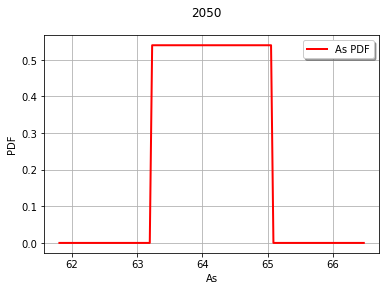

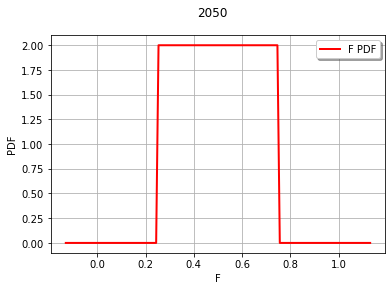

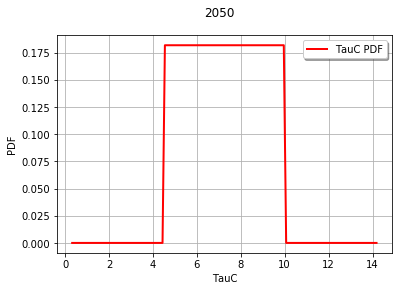

In [18]:
for i in range(inputDimension):
    marginale = inputDistribution.getMarginal(i)
    graph = marginale.drawPDF()
    graph.setTitle("%d" % (annee))
    view = otv.View(graph)

## Modèle probabiliste de l'âge en fonction de l'année

In [19]:
def createHSVColor(indexCurve,maximumNumberOfCurves):
    '''Create a HSV color for the indexCurve-th curve
    from a sample with maximum size equal to maximumNumberOfCurves'''
    color = ot.Drawable.ConvertFromHSV(indexCurve * 360.0/maximumNumberOfCurves, 1.0, 0.9)
    return color

In [20]:
graph = ot.Graph("Loi de l'âge de départ en retraite effectif moyen", "Age", 'PDF', True)

2020
2025
2030
2040
2050
2060
2070


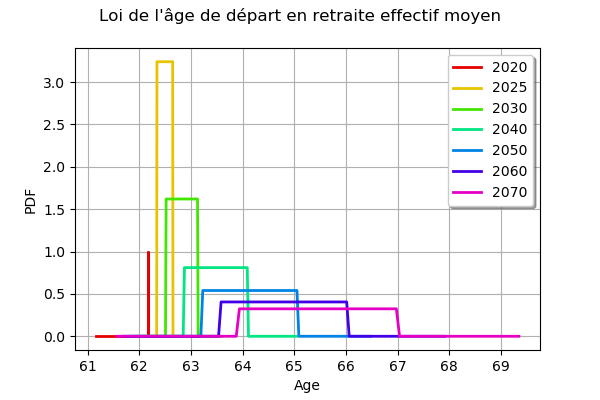

In [21]:
nbannees = len(simulateur.annees_standard)
tableAges = ot.Sample(nbannees, 3)
for i in range(nbannees):
    annee = simulateur.annees_standard[i]
    print(annee)
    modele = CalculeModele(simulateur, annee)
    inputDistribution = modele.getInputDistribution()
    marginaleAge = inputDistribution.getMarginal(0)
    graphPDF = marginaleAge.drawPDF()
    graphPDF.setColors([createHSVColor(i,nbannees)])
    graph.add(graphPDF)
graph.setLegends([str(a) for a in simulateur.annees_standard])
graph.setLegendPosition("topright")
graph

## Analyse en tendance centrale en 2050

In [22]:
annee = 2050
modele = CalculeModele(simulateur, annee)

In [23]:
fonctionPension = modele.getFonction()
inputDistribution = modele.getInputDistribution()

In [24]:
inputRandomVector = ot.RandomVector(inputDistribution)
outputRandomVector = ot.CompositeRandomVector(fonctionPension, inputRandomVector)

In [25]:
sampleSize = 10000
sampleP = outputRandomVector.getSample(sampleSize)

In [26]:
kernel = ot.KernelSmoothing()
fittedDist = kernel.build(sampleP)

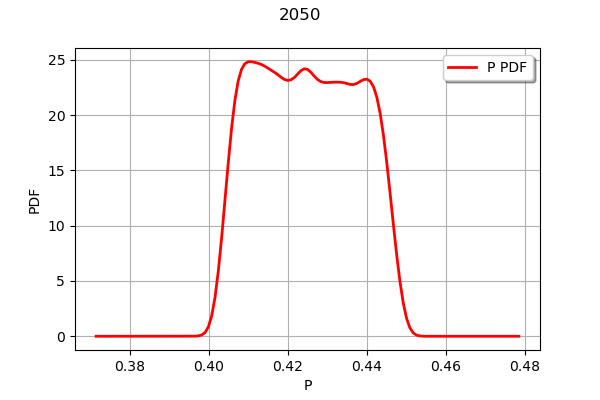

In [27]:
graph = fittedDist.drawPDF()
graph.setTitle("%d" % (annee))
graph

## Sensibilité à l'année

In [28]:
title = "Distribution de (pension moyenne) / (salaire moyen)"
xTitle = "P"
yTitle = "PDF" 
showAxes = True
graph = ot.Graph(title, xTitle, yTitle, showAxes)
sampleSize = 10000
nb_annees = len(simulateur.annees_standard)
for i in range(nb_annees):
    annee = simulateur.annees_standard[i]
    print(annee)
    modele = CalculeModele(simulateur, annee)
    inputDistribution = modele.getInputDistribution()
    fonctionPension = modele.getFonction()
    inputRandomVector = ot.RandomVector(inputDistribution)
    outputRandomVector = ot.CompositeRandomVector(fonctionPension, inputRandomVector)
    sampleP = outputRandomVector.getSample(sampleSize)
    kernel = ot.KernelSmoothing()
    fittedDist = kernel.build(sampleP)
    pdfP = fittedDist.drawPDF()
    pdfP.setColors([createHSVColor(i,nb_annees)])
    graph.add(pdfP)
graph.setLegends([str(a) for a in simulateur.annees_standard])
graph.setLegendPosition("topleft")

2020
2025
2030
2040
2050
2060
2070


In [29]:
def setGraphBoundingBox(graph, xmin = None, xmax = None, ymin = None, ymax = None):
    """
    Set the bounding box in a graph with keywords.
    
    Parameters
    xmin : the x minimum value
    xmax : the x maximum value
    ymin : the y minimum value
    ymax : the y maximum value
    """
    boundingBox = graph.getBoundingBox()
    lb = boundingBox.getLowerBound()
    ub = boundingBox.getUpperBound()
    if xmin is not None:
        lb[0] = xmin
    if ymin is not None:
        lb[1] = ymin
    if xmax is not None:
        ub[0] = xmax
    if ymax is not None:
        ub[1] = ymax
    boundingBox.setLowerBound(lb)
    boundingBox.setUpperBound(ub)
    graph.setBoundingBox(boundingBox)
    return graph

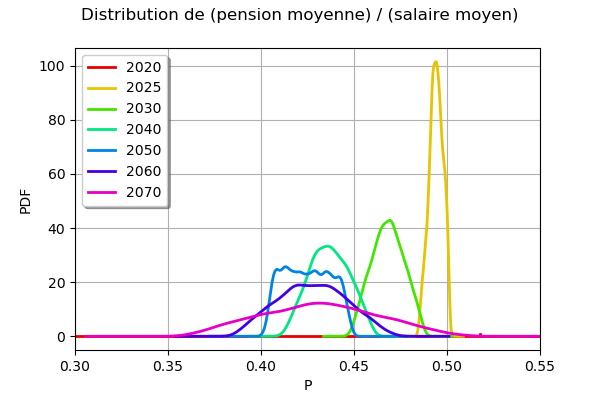

In [30]:
setGraphBoundingBox(graph, xmin = 0.30, xmax = 0.55)
graph